In [1]:
%load_ext autoreload
%autoreload 2


import time
import pickle 
import warnings
import scipy
import scipy.sparse.linalg
from collections import defaultdict

from numpy import matrix, asmatrix
from scipy.sparse.sputils import asmatrix

import random
import numpy as np
import fastmat as fm  # need 0.2a3 or later?

import matplotlib.gridspec as gridspec
warnings.filterwarnings("ignore")
from pylab import rcParams
from matplotlib import container
from matplotlib import pyplot as plt
from IPython.core.display import  HTML

import os, sys
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
os.environ['PRJ'] = "/Users/ymohit/skigp/"

## Loading modules from source 
from src.data import DataLoader
from src.data import get_num_dims
from src.data import DEFAULT_NUMPY_DTYPE
from src.config import DatasetType, Structdict, Frameworks, GsGPType


from src.nmpy.gpoperators import GsGpLinearOperator, KissGpLinearOperator
from src.nmpy.kissgp import KissGpExp
from src.nmpy.gsgp import GsGpExp
from src.utils import tic, toc, toc_report 


#from src.nmpy.solvers import cg
random.seed(1337)
np.random.seed(1337)


import os 
import decimal
from collections import defaultdict
# create a new context for this task
ctx = decimal.Context()

# 20 digits should be enough for everyone :D
ctx.prec = 4

def float_to_str(f):
    """
    Convert the given float to a string,
    without resorting to scientific notation
    """
    d1 = ctx.create_decimal(repr(f))
    return format(d1, 'f')


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/Users/ymohit/skigp/src/nmpy/cg_variants.py:247: DeprecationWarning: invalid escape sequence \c
  '''


In [2]:
    
class Dump(object):
    
    def __init__(self, fname,):

        self.fname = fname
        assert os.path.exists(fname), fname + " does not exists!"

        self.data_time, self.inf_time, self.num_iters, self.l2norm = self.extract_values(fname)     
         
    
    def extract_values(self, fname):

        assert os.path.exists(fname), fname
        fid = open(fname, "r")
        c = fid.read()
        fid.close()

        #print(fname)
        time1 = float(list(filter(lambda x: ("DataGP" in x), c.split("\n")))[0].split("wall=")[1].split(" ms")[0])
        time2 = float(list(filter(lambda x: ("InfGP" in x), c.split("\n")))[0].split("wall=")[1].split(" ms")[0])
        num_iters = int(
            list(filter(lambda x: ("NumIters:" in x), c.split("\n")))[0].split("NumIters")[-1].split(" ")[-1])
        l2norm = float(list(filter(lambda x: ("L2norm: " in x), c.split("\n")))[0].split(" ")[-1])
        
        return time1, time2, num_iters, l2norm

    def get_att(self, att_name='#iters'):

        if att_name == attributes[0]:
            return self.num_iters
        elif att_name == attributes[1]:
            return self.inf_time / self.num_iters
        elif att_name == attributes[2]:
            return self.data_time + self.inf_time
        elif att_name == attributes[3]:
            return self.data_time
        elif att_name == attributes[4]:
            return self.inf_time
        elif att_name == attributes[5]:
            return self.l2norm
        else:
           raise NotImplementedError

def plot_attribute(dumps, attribute='#iters', x_logscale=False, y_logscale=False):
    MS = 8
    methods = ['kissgp', 'gsgp']

    use_seconds = True

    fig, axs = plt.subplots(1, figsize=(10, 8))
    ax = axs

    Xs = []
    for dump_key in dumps.keys():
        Xs += dump_key[0],
    Xs = np.array(sorted(Xs))

    Ys = defaultdict(list)

    for dump_keys, dump_value in dumps.items():
        if dump_keys[-1] == 'kissgp':
            Ys[(dump_keys[0], 'kissgp')] += dump_value.get_att(attribute),
        else:
            Ys[(dump_keys[0], 'gsgp')] += dump_value.get_att(attribute),

    # Plotting data for grid_size_f for all methods seperately
    for method in methods:

        # Collecting data for specific method
        Ys_method = dict()
        for key, value in Ys.items():
            if key[1] != method:
                continue
            Ys_method[key[0]] = value

        Ys_mean = np.array([np.mean(Ys_method[_xs]) for _xs in Xs])
        Ys_std = np.array([np.std(Ys_method[_xs]) for _xs in Xs])

        ## temporary mapping
        #             fmt, marker = get_fmt(m_map[method], gsf)

        if use_seconds and ("time" in attribute or "total" == attribute):
            Ys_mean = Ys_mean / 1e3
            Ys_std = Ys_std / 1e3

        if method == "kissgp":
            lc = "b"
            fmt = lc + ":"
            marker = "P"
        elif method == "gsgp":
            lc = "k"
            fmt = lc + '-'  # dotted line style
            marker = "^"
            
        ax.errorbar(Xs, Ys_mean, yerr=Ys_std, fmt=fmt, marker=marker,
                    markersize=MS, label=method)

    handles, labels = ax.get_legend_handles_labels()
    handles = [h[0] if isinstance(h, container.ErrorbarContainer) else h for h in handles]
    ax.legend(handles, labels)

    if x_logscale:
        ax.set_xscale('log')
    if y_logscale:
        ax.set_yscale('log')

    if ("time" in attribute or "total" == attribute):
        if use_seconds:
            plt.ylabel("Inference time (seconds)")
        else:
            plt.ylabel("Inference time (miliseconds)")

    # plt.xlabel("Number of samples")
    params = {'legend.fontsize': 10}
    plt.rcParams.update(params)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()
    display(HTML("</TD></TR></TABLE>"))
    

attributes = ['#iters', "time/iter", 'total', "time-preprocess", 'inf_time', 'l2norm']
methods = ['kissgp', 'gsgp']

log_dir = os.environ['PRJ'] + "logs/sound_fixed_tol_ski_cov_ref/"

num_repeats = 20
num_samples="1000 2000 5000 6000 8000 10000 30000 60000".split(" ") # #50000 100000 1000000" # 10000000"


dumps = {}

for num_sample in num_samples:
    for run_index in range(1, num_repeats+1):
        for method in range(1, len(methods)+1):
            log_name = log_dir +  "rid_" + str(run_index) + "_method_" + str(method) + "_ns_" + str(num_sample)
            dumps[(int(num_sample), run_index, methods[method-1])] = Dump(log_name + "/std.out")  

In [3]:
def plot_error_vs_time(dumps, x_logscale=False, y_logscale=False, x_label=None, y_label=None, save_path=None):
    
    MS = 10
    methods = ['kissgp', 'gsgp']
    
    use_seconds = True

    fig, axs = plt.subplots(1, figsize=(10, 8))
    ax = axs

    ms = []
    for dump_key in dumps.keys():
        ms += dump_key[0],
    ms = np.array(sorted(ms))
    
    ## Collecting inference error 
    Ys = defaultdict(list)
    attribute = 'l2norm'
    for dump_keys, dump_value in dumps.items():
        if dump_keys[-1] == 'kissgp':
            Ys[(dump_keys[0], 'kissgp')] += np.abs(dump_value.get_att(attribute)),
        else:
            Ys[(dump_keys[0], 'gsgp')] += np.abs(dump_value.get_att(attribute)),

    ## Collecting inference time
    Xs = defaultdict(list)
    attribute = 'total'
    for dump_keys, dump_value in dumps.items():
        if dump_keys[-1] == 'kissgp':
            Xs[(dump_keys[0], 'kissgp')] += dump_value.get_att(attribute),
        else:
            Xs[(dump_keys[0], 'gsgp')] += dump_value.get_att(attribute),
            
                
    # Plotting data for grid_size_f for all methods seperately
    for method in methods:
                        
        # Collecting data for specific method
        Ys_method = dict()
        for key, value in Ys.items():
            if key[1] != method:
                continue
            Ys_method[key[0]] = value

        ## Computed errors
        Ys_mean = np.array([np.mean(Ys_method[_ms]) for _ms in ms])
        Ys_std = np.array([np.std(Ys_method[_ms]) for _ms in ms])


        # Collecting data for specific method
        Xs_method = dict()
        for key, value in Xs.items():
            if key[1] != method:
                continue
            Xs_method[key[0]] = value
        Xs_mean = np.array([np.mean(Xs_method[_ms]) for _ms in ms])
        Xs_std = (1.96/np.sqrt(20)) * np.array([np.std(Xs_method[_ms]) for _ms in ms])

        if use_seconds:
            Xs_mean = Xs_mean / 1e3
            Xs_std = Xs_std / 1e3

            
        if method == "kissgp":
            lc = "b"
            fmt = lc + "-"
            marker = "P"
        elif method == "gsgp":
            lc = "k"
            fmt = lc + '-'  # dotted line style
            marker = "^"
        ax.errorbar(Xs_mean, Ys_mean, yerr=Ys_std, xerr=Xs_std, fmt=fmt, marker=marker,
                    markersize=MS, label="SKI" if method == 'kissgp' else "GSGP",  
                   elinewidth=3, linewidth=3,
                                uplims=True, lolims=True, xuplims=True, xlolims=True)
        
#         ax.errorbar(Xs_mean, Ys_mean, yerr=Ys_std, xerr=Xs_std, fmt=fmt, marker=marker,
#                     markersize=MS, label=method)

#     handles, labels = ax.get_legend_handles_labels()
#     handles = [h[0] if isinstance(h, container.ErrorbarContainer) else h for h in handles]
#     ax.legend(handles, labels, fontsize=30)

#     if x_logscale:
#         ax.set_xscale('log')
#     if y_logscale:
#         ax.set_yscale('log')
        
#     if x_label is not None:
#         plt.xlabel(x_label, fontsize=30)
#     if y_label is not None:
#         plt.ylabel(y_label, fontsize=30)
        
#     if save_path is not None:
#         plt.savefig(save_path, dpi=2400)    

#     params = {'legend.fontsize': 30}
#     plt.rcParams.update(params)
#     plt.xticks(fontsize=50)
#     plt.yticks(fontsize=50)
#     plt.show()
#     display(HTML("</TD></TR></TABLE>"))

    handles, labels = ax.get_legend_handles_labels()
    handles = [h[0] if isinstance(h, container.ErrorbarContainer) else h for h in handles]
    ax.legend(handles, labels, fontsize=30)

    if x_logscale:
        ax.set_xscale('log')
    if y_logscale:
        ax.set_yscale('log')

    if x_label is not None:
        plt.xlabel(x_label, fontsize=35)
    if y_label is not None:
        plt.ylabel(y_label, fontsize=35)
        

    params = {'legend.fontsize': 30, 'axes.linewidth':5}
    plt.rcParams.update(params) 
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    #plt.show()
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=2400)  
    display(HTML("</TD></TR></TABLE>"))


In [4]:
m_val = 8000

print("\n\nComparing total time: ")
att_name = 'total'
dumps_kissgp = [dump_value.get_att(att_name) for dump_keys, dump_value in dumps.items() if (dump_keys[0] == m_val and dump_keys[2] == 'kissgp')]
dumps_gsgp = [dump_value.get_att(att_name) for dump_keys, dump_value in dumps.items() if (dump_keys[0] == m_val and dump_keys[2] == 'gsgp')]

print("Kissgp time (in ms):", np.mean(dumps_kissgp))
print("Gsgp time (in ms):", np.mean(dumps_gsgp))

print("Improvement:", np.mean(dumps_kissgp)/np.mean(dumps_gsgp))



Comparing total time: 
Kissgp time (in ms): 117055.611
Gsgp time (in ms): 50609.175500000005
Improvement: 2.3129325827487546


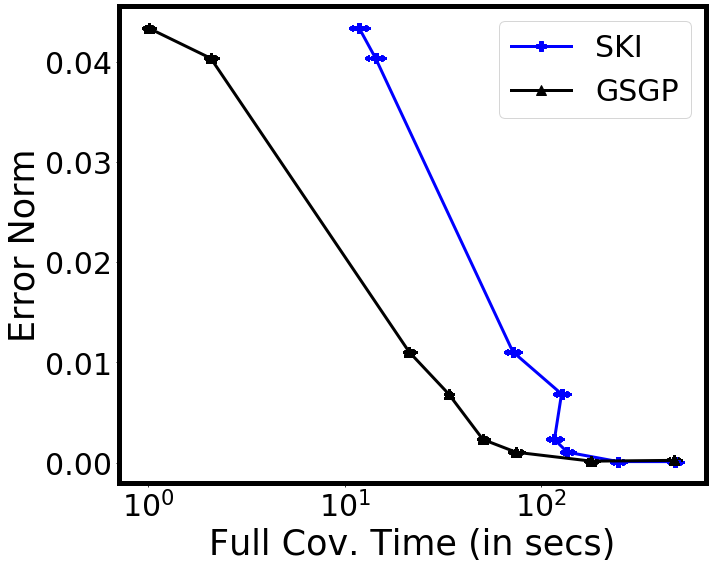

In [6]:
### Inference error (SMAE) versus inference time for fixed tolerance and varrying m 
plot_error_vs_time(dumps, x_logscale=True, y_logscale=False, 
                   y_label='Error Norm', x_label =  'Full Cov. Time (in secs)',
                   save_path='/Users/ymohit/Documents/AISTATS2021/revised_figs/'  
                   + 'sound_ski_cov_error_versus_inf_time' + '.pdf')

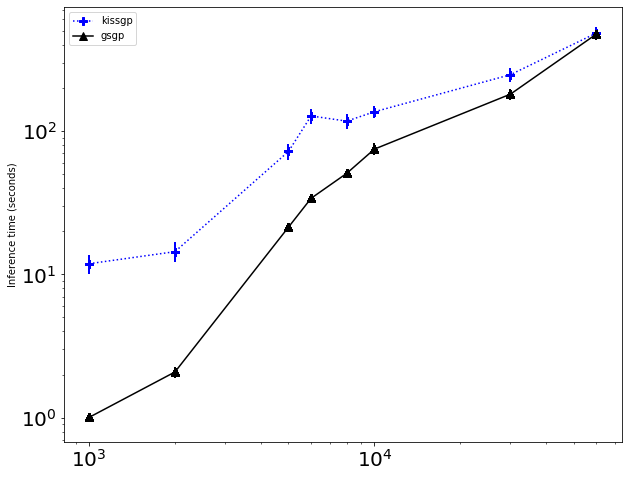

In [4]:
plot_attribute(dumps,attribute='total', x_logscale=True, y_logscale=True)

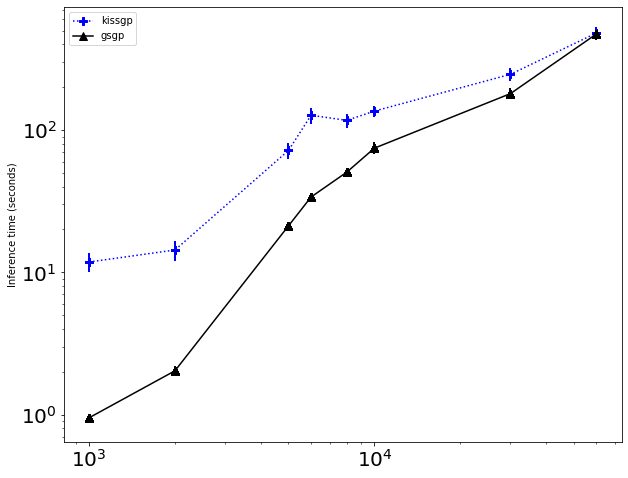

In [5]:
plot_attribute(dumps,attribute='inf_time', x_logscale=True, y_logscale=True)

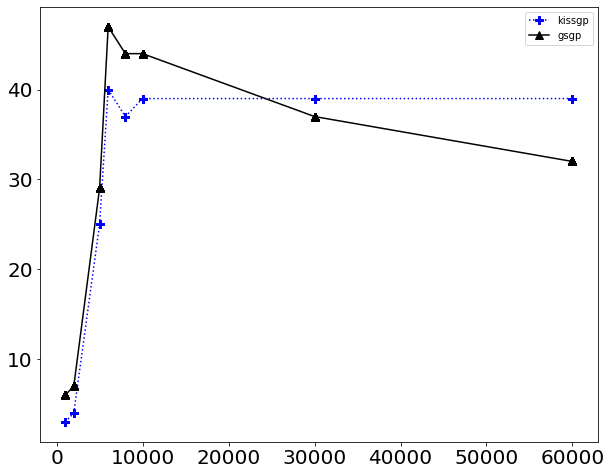

In [6]:
plot_attribute(dumps,attribute='#iters', x_logscale=False, y_logscale=False)

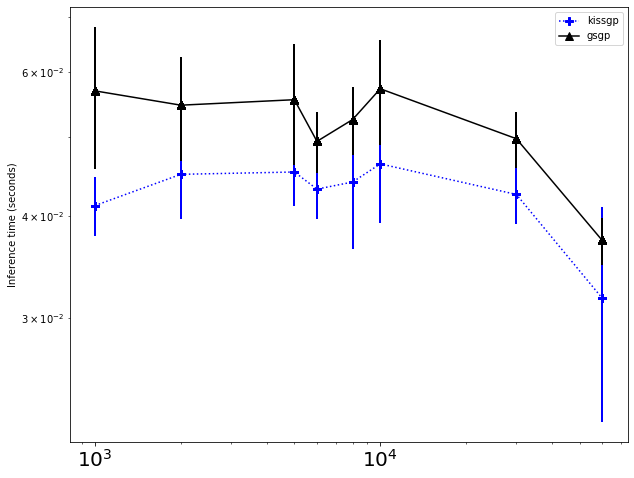

In [7]:
plot_attribute(dumps,attribute='time-preprocess', x_logscale=True, y_logscale=True)